# Capstone 2 -- Post-Segmentation EDA

## Introduction

This is notebook is notebook 5 of Springboard Capstone 2 covering post segmentation EDA. The previous notebooks covered 1. Data Wrangling, 2. EDA, 3. Preprocessing and Training Development, and 4. Modeling and Model Evaluation.

**The Data**<br>
The Data is derived from the Online Retail II dataset from the UCI machine learning repository. The original dataset was a collection of all online transations from a UK based retail company from 01/12/2009 to 09/12/2011.

The data was was cleaned to remove all cancelled orders, any duplicates and other miscelaneous items that needed cleaning. The data was then split into two dataframes, one with known customers and one with unknown customers. The unknown customer data was set aside and the known customer data was grouped by customer and transformed into a Recency, Frequency, Monetary (rfm) dataset.

Using basic rfm and rfm with additional features, the previous notebooks compared 2 KMeans models to get the best customer segments. The basic rfm data from Model 1 using k=2 was found to be the best segmentation combination.  However k=2 doen not provide much value for marketing purposes.  The next best option was Model 1 using k=4.  Both labels were saved for future comparison but k=4 will be the focus here.

**The Goal**<br>
The goal with this notebook is to re-explore the original data with the addition of the segment labels.

## Imports and Default Settings

#### Import Packages

In [317]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import warnings

#### Set Default Preferences

In [319]:
# display all columns
pd.set_option('display.max_columns', None)

# surpress scientific notation
pd.options.display.float_format = '{:}'.format

# Suppress FutureWarning messages
# warnings.simplefilter(action='ignore', category=FutureWarning)

#### Import Data

##### About the Imported Data

We will import 4 datasets. 

The data to be imported: 
* 'has_id.csv':
    * Data from the original Online Retail II dataset limited to entries that have a value in the 'Customer ID' comlum
* 'rfm_expanded.csv':
    * RFM calculations from original dataset after grouping data by 'Customer ID' plus Average Order Value (AOV), Lifetime, and Customer Lifetime Value (CLV) calculations.  Though the expanded features weren't helpful for segmentation they could still provide useful information about the customers in each segment. 
* 'labeled_rfm_scaled.csv':
    * This is the scaled data used in the model with the addition of the cluster labels for k=2 and k=4. Saved with 'Customer ID' as the index.
* 'centroids_4':
    * standardized centroid values from Model 1, k=4

##### Import 'has_id'

In [324]:
## Basic import to check dtypes

# has_id = pd.read_csv('../Data/has_id.csv')
# has_id.info()
# has_id.YearMonth.head()

In [325]:
## import with correct data types

# Set dtypes
dtype_dict={'Invoice':'string', 
            'StockCode':'string',
            'Description':'string',
            'Quantity':'int64',
            'Price':'float64',
            'Customer ID':'string',
            'Country':'category',
            'Sales':'float64'}
# import
has_id = pd.read_csv('../Data/has_id.csv', dtype = dtype_dict, parse_dates = ['InvoiceDate'])

# correct YearMonth to monthly period
has_id['YearMonth'] = pd.PeriodIndex(has_id['YearMonth'], freq='M')

has_id.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 779425 entries, 0 to 779424
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      779425 non-null  string        
 1   StockCode    779425 non-null  string        
 2   Description  779425 non-null  string        
 3   Quantity     779425 non-null  int64         
 4   InvoiceDate  779425 non-null  datetime64[ns]
 5   Price        779425 non-null  float64       
 6   Customer ID  779425 non-null  string        
 7   Country      779425 non-null  category      
 8   Sales        779425 non-null  float64       
 9   YearMonth    779425 non-null  period[M]     
dtypes: category(1), datetime64[ns](1), float64(2), int64(1), period[M](1), string(4)
memory usage: 54.3 MB


##### Import 'rfm_extended'

In [327]:
## import to check dtypes then correct dtypes
# rfm_expanded = pd.read_csv('../Data/rfm_expanded.csv')
rfm_expanded = pd.read_csv('../Data/rfm_expanded.csv', dtype={'Customer ID':'string'})
rfm_expanded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5878 entries, 0 to 5877
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Customer ID  5878 non-null   string 
 1   Recency      5878 non-null   int64  
 2   Frequency    5878 non-null   int64  
 3   Monetary     5878 non-null   float64
 4   AOV          5878 non-null   float64
 5   Lifespan     5878 non-null   int64  
 6   CLV          5878 non-null   float64
dtypes: float64(3), int64(3), string(1)
memory usage: 321.6 KB


##### Import 'labeled_rfm_scaled'

In [329]:
## import to check dtypes then correct dtypes
# labeled_rfm_scaled = pd.read_csv('../Data/labeled_rfm_scaled.csv')
labeled_rfm_scaled = pd.read_csv('../Data/labeled_rfm_scaled.csv', dtype={'Customer ID':'string'})

labeled_rfm_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5878 entries, 0 to 5877
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Customer ID  5878 non-null   string 
 1   Recency      5878 non-null   float64
 2   Frequency    5878 non-null   float64
 3   Monetary     5878 non-null   float64
 4   k2_cluster   5878 non-null   int64  
 5   k4_cluster   5878 non-null   int64  
dtypes: float64(3), int64(2), string(1)
memory usage: 275.7 KB


In [330]:
## import to check columns then correct 
# centroids_4 = pd.read_csv('../Data/centroids_4.csv')
centroids_4 = pd.read_csv('../Data/centroids_4.csv', index_col=0)

centroids_4

,Recency,Frequency,Monetary
0,-0.9660233,1.190121,1.10117
1,1.0283006,-1.0848932,-1.0310698
2,0.60909724,0.26076064,0.24631132
3,-0.75092703,-0.43853897,-0.37525156


#### Add Cluster Labels to Datasets


##### About

The cluster labels in 'labeled_rfm_scaled' need to be added to the other two datasets before post-segmentation EDA.  All data from 'has_id' and 'rfm_expanded' will stay with columns 'k2_cluster' and 'k4_cluster' being added from 'labeled_rfm_scaled'.  'rfm_expanded' is grouped by 'Customer ID' wile 'has_id' has all transactions so they will not be combined.

**NOTE**: The clusters represent the clusters identifiedby a K-Means model using only RFM data.  So even though the rfm_expanded dataset it being used in EDA, the clusters only represent RFM based clusters not the clusters found in the model that used the rfm_expanded data.

##### Add Labels



In [335]:
## has_id

labeled_has_id = has_id.merge(labeled_rfm_scaled[['Customer ID', 'k2_cluster', 'k4_cluster']], on='Customer ID', how='left')
# has_id_labeled.info()
labeled_has_id.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Sales,YearMonth,k2_cluster,k4_cluster
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4,2009-12,1,2
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,2009-12,1,2
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,2009-12,1,2
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.1,13085.0,United Kingdom,100.8,2009-12,1,2
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0,2009-12,1,2


In [336]:
## rfm_expanded

labeled_rfm_expanded = rfm_expanded.merge(labeled_rfm_scaled[['Customer ID', 'k2_cluster', 'k4_cluster']], on='Customer ID', how='left')
# labeled_rfm_expanded.info()
labeled_rfm_expanded.head()

,Customer ID,Recency,Frequency,Monetary,AOV,Lifespan,CLV,k2_cluster,k4_cluster
0,12346.0,326,12,77556.46,6463.038411458333,582,45137860.265625,1,0
1,12347.0,2,8,4921.53,615.1912231445312,582,2864330.3349609375,1,0
2,12348.0,75,5,2019.4,403.8800048828125,582,1175290.8142089844,1,2
3,12349.0,19,4,4428.69,1107.1724853515625,582,2577497.5458984375,1,0
4,12350.0,310,1,334.4,334.3999938964844,582,194620.7964477539,0,1


## Explore

This post-sgementation Eda will focus on finding the characteristics of each Cluster and differences between the clusters with a focus on marketing benefits.

with out What questions do I want to answer?
* Characteristics of each segment:
    * frequency
    * amount
    * top products
    * average order
    * seasonality of sales
* differences between segments:
    * who spend the most
    * who buys most often
    * 

Monetary, Frequency, AOV, CLV, Recency, Country, Description, Quantity, Lifetime

retension rate -- recency and frequency by cluster

identify high value purchases -- aov and clv by cluster


In [341]:
labeled_has_id.columns

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country', 'Sales', 'YearMonth', 'k2_cluster',
       'k4_cluster'],
      dtype='object')

In [342]:
labeled_rfm_expanded.columns

Index(['Customer ID', 'Recency', 'Frequency', 'Monetary', 'AOV', 'Lifespan',
       'CLV', 'k2_cluster', 'k4_cluster'],
      dtype='object')

### RFM Evaluation / Centroids Comparison

NOTE: Recency should have been inverted after standardization and before running the model as more recent purchase will have lower values.  I will invert the Recency in the centroids_4 for consistency in the values.

The centroids from Model 1 are standardized to the rfm dataset used in the model.  The positive and negative values represent higher than average and lower than average values in comparison to the dataset as a whole.

In [847]:
##### create adjusted centriods_4 with inverted Recency #####
centroids = centroids_4.copy(deep=True)
centroids['Recency'] = centroids['Recency']*-1
print('Model 1 Centroids')
centroids

Model 1 Centroids


,Recency,Frequency,Monetary
0,0.9660233,1.190121,1.10117
1,-1.0283006,-1.0848932,-1.0310698
2,-0.60909724,0.26076064,0.24631132
3,0.75092703,-0.43853897,-0.37525156


The centroids Suggest these preliminary profiles for customers:

* Cluster 0: High recency, high frequency, high lifetime spend
    * Frequent, Loyal customers
* Cluster 1: low recency, frequency and spend
    * one time purchases / churned
* Cluster 2: moderately low recency, slighty elevated frequency and spend
    * occasional buyers / risk of churn
* Cluster 3: moderayely high recency low frequency , low spend
    * new customers 


### Characteristics - Univariate

The dataset is highly skewed with some very high outliers. The 95th percentile gives added insight when the max is significantlt higher than the 75th percentile.

In [349]:
##### Set percentiles for .describe()#####

percentiles=[.25, .5, .75, .95]

#### How long have they been customers?  ('Lifespan')
* Answer: The distrbution of lifespan is very similar between the clusters. 

In [351]:
labeled_rfm_expanded.groupby('k4_cluster')['Lifespan'].describe().round(2)

,count,mean,std,min,25%,50%,75%,max
k4_cluster,,,,,,,,
0,1640.0,603.96,199.05,1.0,547.0,706.0,731.0,739.0
1,1634.0,593.44,205.28,1.0,498.75,705.5,730.0,739.0
2,1372.0,590.3,214.58,1.0,497.0,705.0,730.0,739.0
3,1232.0,605.43,198.62,1.0,592.25,706.0,730.0,739.0


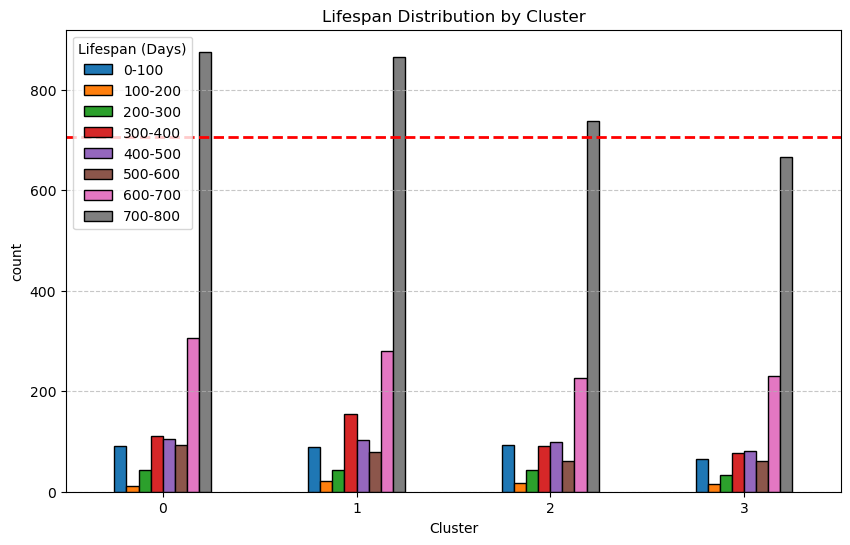

In [905]:
# Define bins and labels
bins = [0, 100, 200, 300, 400, 500, 600, 700, 800]
labels = ['0-100', '100-200', '200-300', '300-400', '400-500', '500-600', '600-700','700-800']

# Create the 'Lifespan_bin' column
labeled_rfm_expanded['Lifespan_bin'] = pd.cut(labeled_rfm_expanded['Lifespan'], bins=bins, labels=labels, right=False)

# Count occurrences of each bin per cluster
bin_counts = labeled_rfm_expanded.groupby(['k4_cluster', 'Lifespan_bin'])['Lifespan'].count().unstack()

# Convert counts 
# Plot the bar chart

bin_counts.plot(kind='bar', figsize=(10, 6), edgecolor='black')

plt.title('Lifespan Distribution by Cluster')
plt.xlabel('Cluster')
plt.ylabel('count')
plt.legend(title='Lifespan (Days)')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.axhline(y=labeled_rfm_expanded['Lifespan'].median(), color='red', linestyle='dashed', linewidth=2, label=f'Median: {labeled_rfm_expanded["Lifespan"].median():.0f}')

# Show the plot
plt.show()


In [1085]:
labeled_rfm_expanded[labeled_rfm_expanded.k4_cluster==3].describe()

,Recency,Frequency,Monetary,AOV,Lifespan,CLV,k2_cluster,k4_cluster,Adj_AOV
count,1232.0,1232.0,1232.0,1232.0,1232.0,1232.0,1232.0,1232.0,1232.0
mean,39.7150974025974,2.36525974025974,662.3404638108766,319.80844424473116,605.4261363636364,401521.2682358661,0.43993506493506496,3.0,199.51674541143845
std,29.9031607781419,1.174337401326921,453.56579568940913,294.6563213883034,198.62367471660485,319946.43660001364,0.4965806678796259,0.0,292.85159961767886
min,1.0,1.0,30.0,7.737499713897705,1.0,77.5,0.0,3.0,1.9343749284744263
25%,17.0,1.0,342.235,169.49750137329102,592.25,180850.6887130737,0.0,3.0,65.49343872070312
50%,32.5,2.0,571.37,255.8300018310547,706.0,328335.8300476074,0.0,3.0,118.6616685655382
75%,58.0,3.0,887.25,371.03125762939453,730.0,546664.2466278076,1.0,3.0,219.36750030517578
max,158.0,7.0,4366.78,4366.77978515625,739.0,3222683.4814453125,1.0,3.0,4366.77978515625


#### How often do they buy? (Frequency)
uses Frequency: number of transactions in df
* Cluster 0: Frequent Buyers - these customers purchase most frequently - IQR 7-17
    - 25,876 purchases (69.99%)
* Cluster 1: One-Time Buyers - these customers purchase once or, rarely, twice
    - 2,016 purchases (5.45%)
* Cluster 2: Ocasional Buyers - these customers purchase second most- IQR 3-5
    - 6,163 purchases (16.67%) 
* Cluster 3: Try Again Buyers - these customers purchase 1-3 times
    - 2,914 purchases (7.88%)

In [354]:
labeled_rfm_expanded.groupby('k4_cluster')['Frequency'].describe(percentiles=[.25, .5, .75, .95]).round(2).T

k4_cluster,0,1,2,3
count,1640.0,1634.0,1372.0,1232.0
mean,15.78,1.23,4.49,2.37
std,21.68,0.45,2.65,1.17
min,2.0,1.0,1.0,1.0
25%,7.0,1.0,3.0,1.0
50%,11.0,1.0,4.0,2.0
75%,17.0,1.0,5.0,3.0
95%,39.0,2.0,9.0,4.0
max,398.0,4.0,41.0,7.0


In [995]:
len(labeled_rfm_expanded[(labeled_rfm_expanded.k4_cluster==1)&(labeled_rfm_expanded.Frequency==1)])/len(labeled_rfm_expanded[(labeled_rfm_expanded.k4_cluster==1)])*100

77.7845777233782

In [355]:
##### Number of purchases by cluster #####

labeled_rfm_expanded.groupby('k4_cluster').Frequency.sum()

k4_cluster
0    25876
1     2016
2     6163
3     2914
Name: Frequency, dtype: int64

In [356]:
print('% of Purchases')

for cluster in range(4):
    purchases = labeled_rfm_expanded.groupby('k4_cluster').Frequency.sum()
    percent = round((purchases[cluster]/purchases.sum()*100), 2)
    print(f'Cluster {cluster}: {percent}% ')

% of Purchases
Cluster 0: 69.99% 
Cluster 1: 5.45% 
Cluster 2: 16.67% 
Cluster 3: 7.88% 


In [357]:
##### Count of purchases in the Top 25th percentile of Frequency #####

for cluster in range(1):
    df = labeled_rfm_expanded[labeled_rfm_expanded.k4_cluster == cluster]
    seven_five = df.Frequency.quantile(.75)
    print(f'Cluster: {cluster}')
    print(df[df.Frequency>seven_five].Frequency.value_counts())
    print('---')

for cluster in range(1,4):
    df = labeled_rfm_expanded[labeled_rfm_expanded.k4_cluster == cluster]
    seven_five = df.Frequency.quantile(.75)
    print(f'Cluster: {cluster}')
    print(df[df.Frequency>seven_five].Frequency.value_counts().sort_index())
    print('---')

Cluster: 0
Frequency
18     32
20     30
19     25
21     23
23     21
       ..
122     1
192     1
151     1
398     1
145     1
Name: count, Length: 73, dtype: int64
---
Cluster: 1
Frequency
2    345
3     17
4      1
Name: count, dtype: int64
---
Cluster: 2
Frequency
6     127
7      78
8      46
9      21
10     10
11     22
12      6
13      6
14      2
15      3
16      2
17      2
19      1
20      1
29      1
41      1
Name: count, dtype: int64
---
Cluster: 3
Frequency
4    157
5     47
6      8
7      2
Name: count, dtype: int64
---


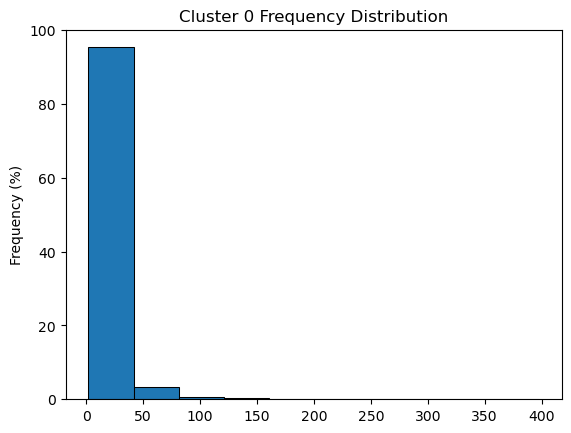

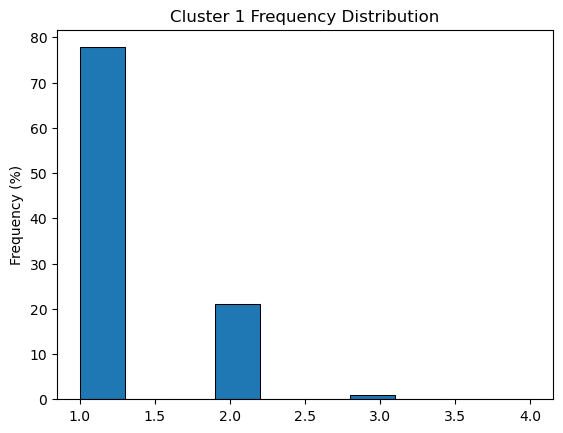

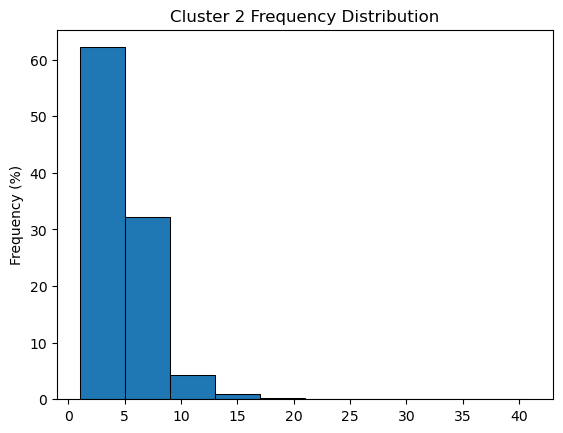

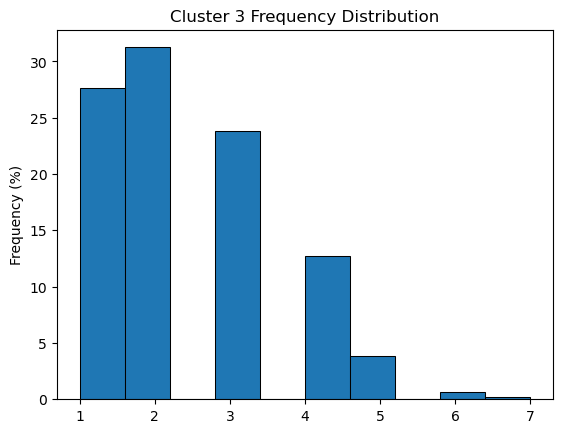

In [358]:
##### Basic frequency distribution #####

for cluster in range(4):
    df = labeled_rfm_expanded[labeled_rfm_expanded.k4_cluster == cluster]
    weights = np.ones(len(df)) * 100 / len(df)
    plt.hist(df.Frequency, weights=weights, edgecolor='black', linewidth=.75)
    plt.title(f'Cluster {cluster} Frequency Distribution')
    plt.ylabel('Frequency (%)')
    plt.show()
    

In [1039]:
# Portion of Frequency > 5 and 10
print('5 or more purchases')
for cluster in range(4):
    df= labeled_rfm_expanded[labeled_rfm_expanded.k4_cluster == cluster]
    portion_5 = len(df[df.Frequency>=5])/len(df)
    portion_10 = len(df[df.Frequency>=10])/len(df)
    portion_2 = len(df[df.Frequency<=2])/len(df)
    portion_1 = len(df[df.Frequency==1])/len(df)

    print(f"Cluster {cluster}: {portion_1*100:.1f}% 1;   {portion_2*100:.1f}% 2 or less;   {portion_5*100:.1f}% 5+;  {portion_10*100:.1f}% 10+")

5 or more purchases
Cluster 0: 0.0% 1;   0.1% 2 or less;   96.6% 5+;  55.9% 10+
Cluster 1: 77.8% 1;   98.9% 2 or less;   0.0% 5+;  0.0% 10+
Cluster 2: 0.9% 1;   16.4% 2 or less;   37.8% 5+;  4.2% 10+
Cluster 3: 27.6% 1;   58.8% 2 or less;   4.6% 5+;  0.0% 10+


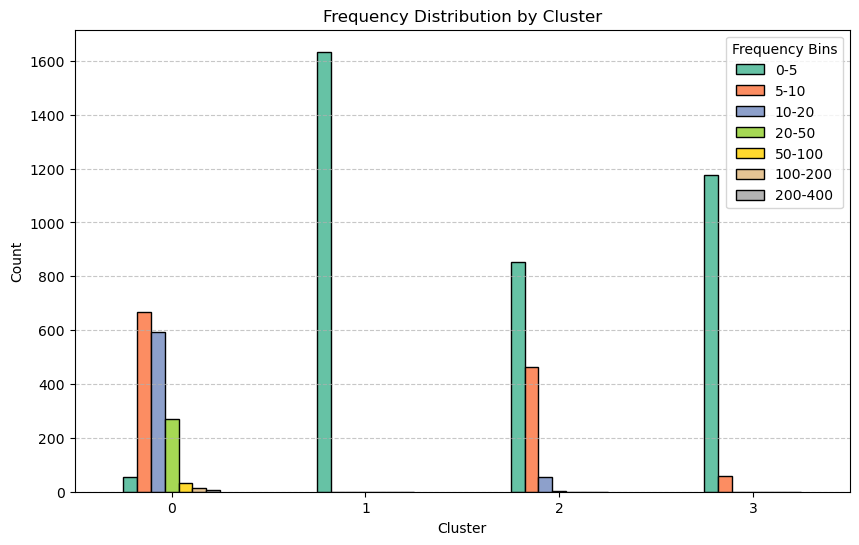

In [967]:
##### more detailed frequency distribution #####

# Define bins and labels
bins = [0, 5, 10, 20, 50, 100, 200, 400]
labels = ['0-5', '5-10', '10-20', '20-50', '50-100', '100-200', '200-400']

# Create the 'Frequency_bin' column
labeled_rfm_expanded['Frequency_bin'] = pd.cut(labeled_rfm_expanded['Frequency'], bins=bins, labels=labels, right=False)

# Count occurrences of each bin per cluster
bin_counts = labeled_rfm_expanded.groupby(['k4_cluster', 'Frequency_bin'])['Frequency'].count().unstack()

# Convert counts to percentages
# bin_percentages = bin_counts.div(bin_counts.sum(axis=1), axis=0) * 100

# Plot the bar chart
bin_counts.plot(kind='bar', figsize=(10, 6), edgecolor='black', colormap='Set2')

plt.title('Frequency Distribution by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.legend(title='Frequency Bins')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)


# plt.savefig("../Images/frequency_distribution_by_cluster.png", dpi=300, bbox_inches="tight")  # Save as PNG
# plt.savefig("../Images/frequency_distribution_by_cluster.svg", dpi=300, bbox_inches="tight")  # Save as SVG

# Show the plot
plt.show()

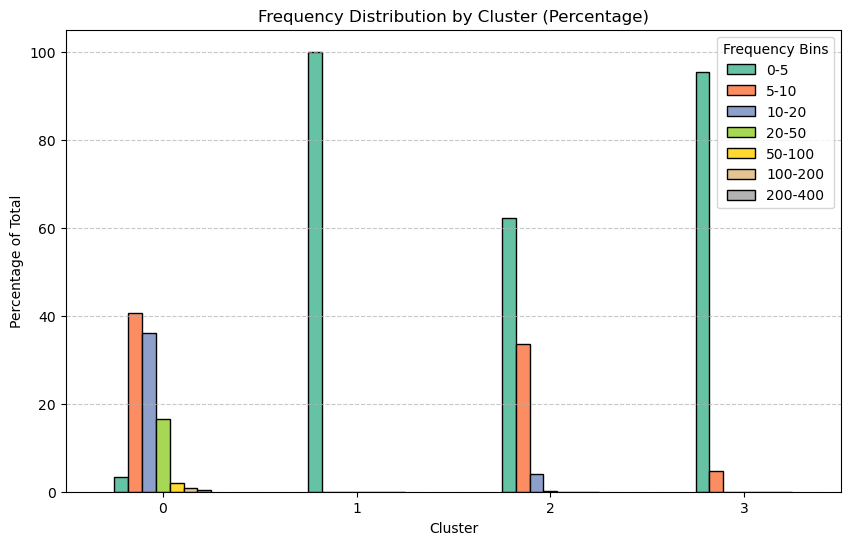

In [969]:
##### more detailed frequency distribution #####

# Define bins and labels
bins = [0, 5, 10, 20, 50, 100, 200, 400]
labels = ['0-5', '5-10', '10-20', '20-50', '50-100', '100-200', '200-400']

# Create the 'Frequency_bin' column
labeled_rfm_expanded['Frequency_bin'] = pd.cut(labeled_rfm_expanded['Frequency'], bins=bins, labels=labels, right=False)

# Count occurrences of each bin per cluster
bin_counts = labeled_rfm_expanded.groupby(['k4_cluster', 'Frequency_bin'])['Frequency'].count().unstack()

# Convert counts to percentages
bin_percentages = bin_counts.div(bin_counts.sum(axis=1), axis=0) * 100

# Plot the bar chart
bin_percentages.plot(kind='bar', figsize=(10, 6), edgecolor='black', colormap='Set2')

plt.title('Frequency Distribution by Cluster (Percentage)')
plt.xlabel('Cluster')
plt.ylabel('Percentage of Total')
plt.legend(title='Frequency Bins')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)


plt.savefig("../Images/frequency_distribution_by_cluster.png", dpi=300, bbox_inches="tight")  # Save as PNG
plt.savefig("../Images/frequency_distribution_by_cluster.svg", dpi=300, bbox_inches="tight")  # Save as SVG

# Show the plot
plt.show()


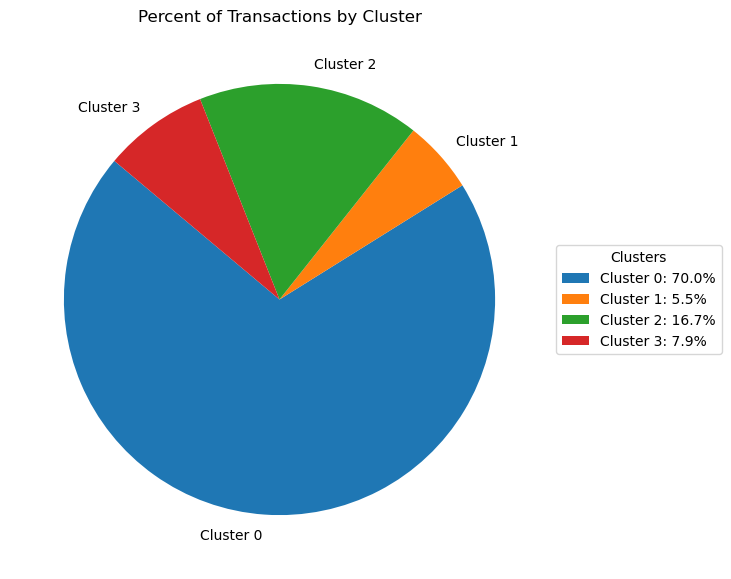

In [360]:
# Visualize 

# Group by cluster and sum the monetary values
freq = labeled_rfm_expanded.groupby('k4_cluster').Frequency.sum()

# Calculate percentages
percentages = (freq / freq.sum()) * 100

# Create labels for the legend (Cluster X: Y%)
legend_labels = [f'Cluster {i}: {percentages[i]:.1f}%' for i in range(4)]

# Create labels for inside the pie chart (Cluster X)
pie_labels = [f'Cluster {i}' for i in range(4)]

# Create the pie chart with only cluster labels inside
plt.figure(figsize=(7,7))
wedges, texts = plt.pie(freq, labels=pie_labels, startangle=140)

# Add a legend with cluster names and percentages
plt.legend(wedges, legend_labels, title="Clusters", loc="center left", bbox_to_anchor=(1, 0.5))
plt.title('Percent of Transactions by Cluster')

plt.savefig("../Images/Transaction_percent.png", dpi=300, bbox_inches="tight")  # Save as PNG
plt.savefig("../Images/Transaction_percent.svg", dpi=300, bbox_inches="tight")  # Save as SVG

plt.show()

#### How much do they spend? (Monetary, AOV, AOV/Frequency, Adj_AOV)

##### Total Spend - Monatary
* Cluster 0: Frequent Buyers - \$13,810,659 spent (79.49%)
* Cluster 1: One-Time Buyers - \$480,270 spent (2.76%)
* Cluster 2: Ocasional Buyers - \$2,267,871.00 spent (13.05%) 
* Cluster 3: Try Again Buyers - \$816,003 spent (4.7%)

In [1003]:
labeled_rfm_expanded.groupby('k4_cluster')['Monetary'].describe().T

k4_cluster,0,1,2,3
count,1640.0,1634.0,1372.0,1232.0
mean,8421.133735957317,293.9231892552019,1652.967198090379,662.3404638108766
std,26467.18646169096,231.6748679569933,2373.8269196145875,453.56579568940913
min,489.54,2.95,167.42,30.0
25%,2268.0350000000003,141.58999999999997,782.635,342.235
50%,3770.2200000000003,240.2,1168.2199999999998,571.37
75%,6948.4025,374.35,1843.5275,887.25
max,580987.06,2300.4,44534.3,4366.78


In [1007]:
# Percent > $1000, 5000, 10,000
print('AOV > 750')
for cluster in range(4):
    df= labeled_rfm_expanded[labeled_rfm_expanded.k4_cluster == cluster]
    portion_1 = len(df[df.Monetary>1000])/len(df)
    portion_5 = len(df[df.Monetary>5000])/len(df)
    portion_10 = len(df[df.Monetary>10000])/len(df)
    portion_100 = len(df[df.Monetary>100000])/len(df)

    print(f"Cluster {cluster}: {portion_1*100:.1f}% 1k+; {portion_5*100:.1f}% 5k+; {portion_10*100:.1f}% 10k+, {portion_100*100:.1f}% 100k+ ")

AOV > 750
Cluster 0: 98.4% 1k+; 37.1% 5k+; 15.2% 10k+, 0.9% 100k+ 
Cluster 1: 2.1% 1k+; 0.0% 5k+; 0.0% 10k+, 0.0% 100k+ 
Cluster 2: 60.1% 1k+; 2.6% 5k+; 0.9% 10k+, 0.0% 100k+ 
Cluster 3: 18.8% 1k+; 0.0% 5k+; 0.0% 10k+, 0.0% 100k+ 


In [363]:
##### Percent of total Spend #####
print('% of total spend')
for cluster in range(4):
    money = labeled_rfm_expanded.groupby('k4_cluster').Monetary.sum()
    percent = round((money[cluster]/money.sum()*100), 2)
    print(f'Cluster {cluster}: {percent}% ')

% of total spend
Cluster 0: 79.49% 
Cluster 1: 2.76% 
Cluster 2: 13.05% 
Cluster 3: 4.7% 


In [364]:
##### Formatted total Spend #####
labeled_rfm_expanded.groupby('k4_cluster').Monetary.sum().round().apply(lambda x: "{:,.2f}".format(x))

k4_cluster
0    13,810,659.00
1       480,270.00
2     2,267,871.00
3       816,003.00
Name: Monetary, dtype: object

In [365]:
##### Sorted total Spend #####

df = labeled_rfm_expanded.groupby('k4_cluster')['Monetary'].sum().round(2)
df = df.reset_index()
df.columns = ["Cluster", "Monetary"]
df.sort_values('Monetary',ascending=False)

,Cluster,Monetary
0,0,13810659.33
2,2,2267871.0
3,3,816003.45
1,1,480270.49


In [366]:
labeled_rfm_expanded.groupby('k4_cluster').CLV.sum().round().apply(lambda x: "{:,.2f}".format(x))

k4_cluster
0    8,519,450,805.00
1      284,829,039.00
2    1,365,330,633.00
3      494,674,202.00
Name: CLV, dtype: object

In [367]:
labeled_rfm_expanded.CLV.sum()

10664284679.788734

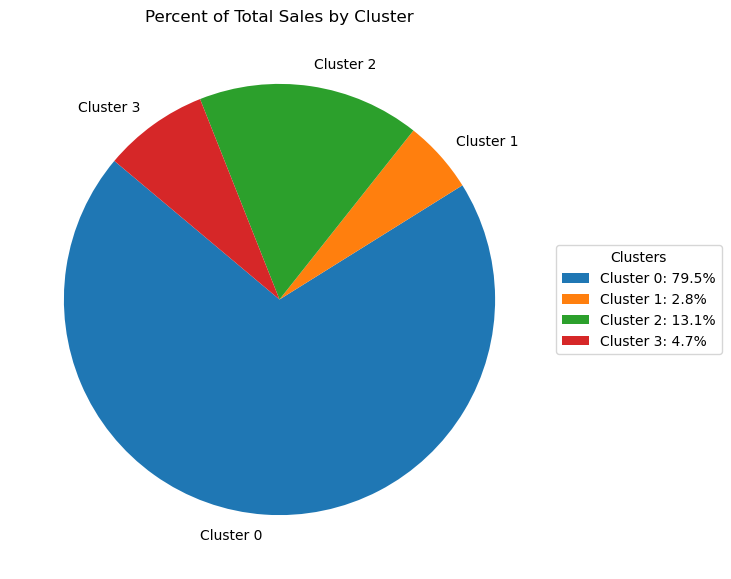

In [1009]:
# Visualize 

# Group by cluster and sum the monetary values
money = labeled_rfm_expanded.groupby('k4_cluster').Monetary.sum()

# Calculate percentages
percentages = (money / money.sum()) * 100

# Create labels for the legend (Cluster X: Y%)
legend_labels = [f'Cluster {i}: {percentages[i]:.1f}%' for i in range(4)]

# Create labels for inside the pie chart (Cluster X)
pie_labels = [f'Cluster {i}' for i in range(4)]

# Create the pie chart with only cluster labels inside
plt.figure(figsize=(7,7))
wedges, texts = plt.pie(freq, labels=pie_labels, startangle=140)

# Add a legend with cluster names and percentages
plt.legend(wedges, legend_labels, title="Clusters", loc="center left", bbox_to_anchor=(1, 0.5))
plt.title('Percent of Total Sales by Cluster')

plt.savefig("../Images/Spend_total_percent.png", dpi=300, bbox_inches="tight")  # Save as PNG
plt.savefig("../Images/Spend_total_percent.svg", dpi=300, bbox_inches="tight")  # Save as SVG

plt.show()

##### Average order value - AOV
* Cluster 0: Frequent Buyers - Median: 351 - IQR 249-509
* Cluster 1: One-Time Buyers - Median: 197 - IQR 124-311
* Cluster 2: Ocasional Buyers - Median: 306 - IQR 199-445
* Cluster 3: Try Again Buyers - Median: 256 - IQR 169-371

In [370]:
labeled_rfm_expanded.groupby('k4_cluster').AOV.describe().round().T

k4_cluster,0,1,2,3
count,1640.0,1634.0,1372.0,1232.0
mean,515.0,255.0,443.0,320.0
std,2122.0,227.0,866.0,295.0
min,29.0,3.0,11.0,8.0
25%,249.0,124.0,199.0,169.0
50%,351.0,197.0,306.0,256.0
75%,509.0,311.0,445.0,371.0
max,84236.0,2300.0,14845.0,4367.0


In [999]:
# Percent > $1000
print('AOV > 750')
for cluster in range(4):
    df= labeled_rfm_expanded[labeled_rfm_expanded.k4_cluster == cluster]
    portion = len(df[df.AOV>750])/len(df)
   

    print(f"Cluster {cluster}: {portion*100:.1f}% ")

AOV > 750
Cluster 0: 11.3% 
Cluster 1: 3.9% 
Cluster 2: 7.9% 
Cluster 3: 4.7% 


##### Average order value by order - AOV/Frequency - 'Adjusted AOV'
* Cluster 0: Frequent Buyers - Mean: 76.44 - Median: 31.59 - IQR 18.22-55.32
    * lowest adjusted AOV --> highest AOV and highest frequency suggests AOV is inflated by Frequent Purchases
* Cluster 1: One-Time Buyers - Mean: 235.79 - Median: 158.97 - IQR 98.37-309.76
    * highest adjusted AOV --> high one time purchases
* Cluster 2: Ocasional Buyers - Mean: 167.21 - Median: 40.83 - IQR 40.83-146.22
    * 2nd lowest adjust AOV --> occasional buyers with higher AOV
* Cluster 3: Try Again Buyers - Mean: 199.52 - Median: 118.66 - IQR 65.49-219.37
    * 2nd highest adjusted AOV --> several bigger purchases

In [372]:
##### Add Adjusted AOV column #####
labeled_rfm_expanded['Adj_AOV'] = labeled_rfm_expanded.AOV/labeled_rfm_expanded.Frequency

In [373]:
labeled_rfm_expanded.groupby('k4_cluster').Adj_AOV.describe().round(2).T

k4_cluster,0,1,2,3
count,1640.0,1634.0,1372.0,1232.0
mean,76.44,235.79,167.21,199.52
std,1042.64,234.85,623.07,292.85
min,0.29,2.95,0.74,1.93
25%,18.22,98.37,40.83,65.49
50%,31.59,158.97,72.18,118.66
75%,55.32,309.76,146.22,219.37
max,42118.12,2300.4,11880.84,4366.78


#### How many items do they buy per purchase? - Quantity
consistent across clusters, top five percent of frequent buyers purchase most


In [1059]:
labeled_has_id.groupby('k4_cluster').Quantity.describe(percentiles=[.25,.5,.75,.8,.85,.9,.95, .96,.97,.98,.99]).round(2).T

k4_cluster,0,1,2,3
count,559711.0,35306.0,119824.0,64584.0
mean,14.58,7.93,13.03,7.89
std,159.93,21.85,136.3,16.66
min,1.0,1.0,1.0,1.0
25%,2.0,1.0,2.0,1.0
50%,6.0,4.0,5.0,4.0
75%,12.0,10.0,12.0,12.0
80%,12.0,12.0,12.0,12.0
85%,20.0,12.0,12.0,12.0
90%,24.0,16.0,24.0,18.0


#### What is the typical Price of items purchases? (Price)
same across all groups


In [1053]:
labeled_has_id.groupby('k4_cluster').Price.describe(percentiles=[.25,.5,.75,.95, .96,.97,.98,.99]).round(2).T

k4_cluster,0,1,2,3
count,559711.0,35306.0,119824.0,64584.0
mean,3.16,3.28,3.67,2.87
std,23.36,8.78,55.65,10.41
min,0.0,0.0,0.0,0.0
25%,1.25,1.25,1.25,0.85
50%,1.95,1.95,1.95,1.65
75%,3.75,3.75,3.75,3.75
95%,8.5,9.95,9.95,8.5
96%,9.95,9.95,9.95,8.95
97%,9.95,10.95,10.95,9.95


#### Do clusters differ by Country? (Country)
Percent of purchases from UK by cluster:
* Cluster 0: 89.05999999999999%; percent difference: -0.89%
* Cluster 1: 93.14%; percent difference: 3.65%
* Cluster 2: 91.23%; percent difference: 1.52%
* Cluster 3: 92.43%; percent difference: 2.86%
<br>
- cluster 0 is most representative of the dataset by country distribution.  It has a slightly lower portion of UK but slightly higher percentage of the other top 5 countries.  It includes all but 2 of the purchases from Ireland.


In [589]:
# Group by 'Country' only and count occurrences
country_counts = labeled_has_id.groupby('Country').size().reset_index(name='Count')

# Convert counts to percentages (relative to total count)
country_counts['Percent'] = (country_counts['Count'] / country_counts['Count'].sum()) * 100

# Get the top 5 countries based on percentage
top_countries = country_counts.nlargest(5, 'Percent').round(2)

# Round the results for better readability
top_countries


,Country,Count,Percent
25,United Kingdom,700388,89.86
9,Germany,16432,2.11
6,EIRE,15565,2.0
8,France,13511,1.73
14,Netherlands,5085,0.65


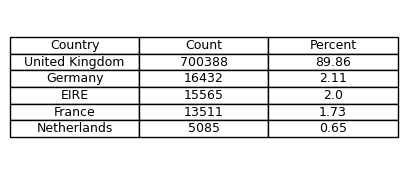

In [591]:
##### save table as an Image #####

# Create a figure and axis for the table
fig, ax = plt.subplots(figsize=(5, 2))  # Adjust size as needed
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=top_countries.values, colLabels=top_countries.columns, cellLoc='center', loc='center')

# Save the table as an image
plt.savefig("../Images/top_countries.png", dpi=300, bbox_inches="tight")
plt.savefig("../Images/top_countries.svg", dpi=300, bbox_inches="tight")
plt.show()

In [581]:
# Group by 'k4_cluster' and 'Country' and count occurrences
country_counts = labeled_has_id.groupby(['k4_cluster', 'Country']).size().reset_index(name='Count')

# Convert counts to percentages within each cluster (fixing the index mismatch issue)
country_counts['Percent'] = country_counts.groupby('k4_cluster')['Count'].transform(lambda x: (x / x.sum()) * 100).round(2)

# Sort within each cluster and get the top 5 countries per cluster based on percentage
top_countries_per_cluster = country_counts.groupby('k4_cluster').apply(lambda x: x.nlargest(5, 'Percent')).reset_index(drop=True)

top_countries_per_cluster

,k4_cluster,Country,Count,Percent
0,0,United Kingdom,498484,89.06
1,0,EIRE,15563,2.78
2,0,Germany,12463,2.23
3,0,France,11456,2.05
4,0,Netherlands,4346,0.78
5,1,United Kingdom,32885,93.14
6,1,France,340,0.96
7,1,Germany,261,0.74
8,1,Sweden,252,0.71
9,1,Spain,244,0.69


In [615]:
# differnce in ireland purchase from cluster 0 to full dataset
top_countries.loc[top_countries["Country"] == "EIRE", "Count"].values[0] - top_countries_per_cluster.loc[
    (top_countries_per_cluster["Country"] == "EIRE") & 
    (top_countries_per_cluster["k4_cluster"] == 0), "Count"
].values[0]


2

In [516]:
top_countries_per_cluster.Country.unique()

['United Kingdom', 'EIRE', 'Germany', 'France', 'Netherlands', 'Sweden', 'Spain', 'Switzerland', 'Belgium', 'Portugal']
Categories (41, object): ['Australia', 'Austria', 'Belgium', 'Channel Islands', ..., 'Czech Republic', 'Lebanon', 'Saudi Arabia', 'European Community']

In [464]:
uk_average = round(len(has_id[has_id.Country=='United Kingdom'])/len(has_id), 4)*100  # .898595

print(f'Percent of purchases from UK for entire dataset: {uk_average}')
print('---')
print('Percent of purchases from UK by cluster:')
for cluster in range(4):
    df = labeled_has_id[labeled_has_id.k4_cluster== cluster]
    cluster_percent_uk = round(len(df[df.Country=='United Kingdom'])/len(df), 4)*100
    print(f'Cluster {cluster}: {cluster_percent_uk}%; percent difference: {round((cluster_percent_uk-uk_average)/uk_average, 4)*100}%')

Percent of purchases from UK for entire dataset: 89.86
---
Percent of purchases from UK by cluster:
Cluster 0: 89.05999999999999%; percent difference: -0.89%
Cluster 1: 93.14%; percent difference: 3.65%
Cluster 2: 91.23%; percent difference: 1.52%
Cluster 3: 92.43%; percent difference: 2.86%


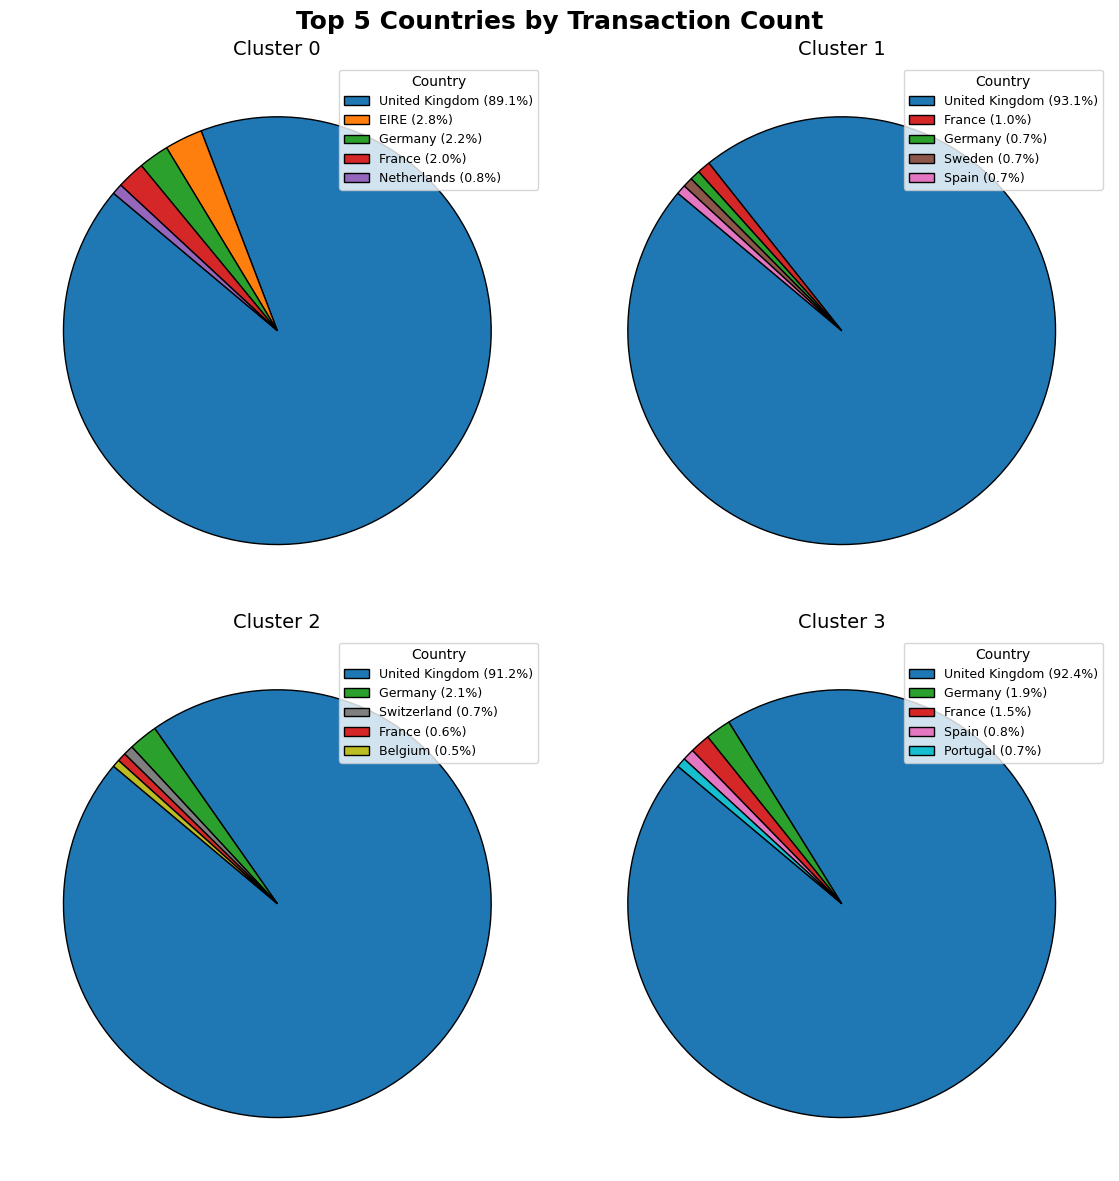

In [889]:
# Creating subplots with only legends, no labels on the plots
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()

# Plot each cluster
for i, cluster in enumerate(top_countries_per_cluster["k4_cluster"].unique()):
    cluster_data = top_countries_per_cluster[top_countries_per_cluster["k4_cluster"] == cluster]

    # Creating the pie chart without labels
    wedges = axes[i].pie(
        cluster_data["Percent"], 
        labels=None,  # Remove labels from the pie chart itself
        autopct=None,  # Remove percentage labels from the pie chart
        colors=[color_map[c] for c in cluster_data["Country"]],
        startangle=140,
        wedgeprops={'linewidth': 1, 'edgecolor': 'black'}
    )[0]  # Only get the wedges

    axes[i].set_title(f"Cluster {cluster}", fontsize=14)

    # Add legend
    legend_labels = [f"{c} ({p:.1f}%)" for c, p in zip(cluster_data["Country"], cluster_data["Percent"])]
    axes[i].legend(wedges, legend_labels, title="Country", loc="upper right", fontsize=9, frameon=True)

# Adjust layout for better spacing
# plt.subplots_adjust(wspace=0.2, hspace=0.2)



fig.suptitle("Top 5 Countries by Transaction Count", fontsize=18, fontweight="bold")
plt.subplots_adjust(wspace=0.4, hspace=0.5, top=0.8)  # Adjust top to fit title properly
plt.tight_layout()

plt.savefig("../Images/top_5_country_count.png", dpi=300, bbox_inches="tight")  # Save as PNG
plt.savefig("../Images/top_5_country_count.svg", dpi=300, bbox_inches="tight")  # Save as SVG

plt.show()


#### How Recently have them purchased

In [1015]:
labeled_rfm_expanded.groupby('k4_cluster')['Recency'].describe().round(2).T

k4_cluster,0,1,2,3
count,1640.0,1634.0,1372.0,1232.0
mean,31.35,431.37,275.67,39.72
std,37.94,172.95,151.89,29.9
min,1.0,30.0,50.0,1.0
25%,8.0,302.0,150.0,17.0
50%,20.0,423.0,248.5,32.5
75%,42.0,572.75,393.0,58.0
max,497.0,739.0,738.0,158.0


In [1037]:
# recency 30,60,90
print('Recency')
for cluster in range(4):
    df= labeled_rfm_expanded[labeled_rfm_expanded.k4_cluster == cluster]
    portion_30 = len(df[df.Recency<=30])/len(df)
    portion_60 = len(df[df.Recency<=60])/len(df)
    portion_90 = len(df[df.Recency<=90])/len(df)
    portion_6m = len(df[df.Recency<=(365/2)])/len(df)
    portion_1y = len(df[df.Recency<=(365)])/len(df)

    print(f"Cluster {cluster}: {portion_1y*100:.1f}% 1yr; {portion_6m*100:.1f}% 6M;  {portion_90*100:.1f}% 90;   {portion_60*100:.1f}% 60;   {portion_30*100:.1f}% 30")

Recency
Cluster 0: 99.8% 1yr; 99.2% 6M;  94.3% 90;   85.8% 60;   64.7% 30
Cluster 1: 30.1% 1yr; 9.1% 6M;  2.3% 90;   0.6% 60;   0.1% 30
Cluster 2: 66.2% 1yr; 34.5% 6M;  10.6% 90;   2.0% 60;   0.0% 30
Cluster 3: 100.0% 1yr; 100.0% 6M;  94.0% 90;   77.4% 60;   47.6% 30


In [1103]:
# c3=labeled_has_id[labeled_has_id.k4_cluster==3]
labeled_has_id.columns

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country', 'Sales', 'YearMonth', 'k2_cluster',
       'k4_cluster'],
      dtype='object')

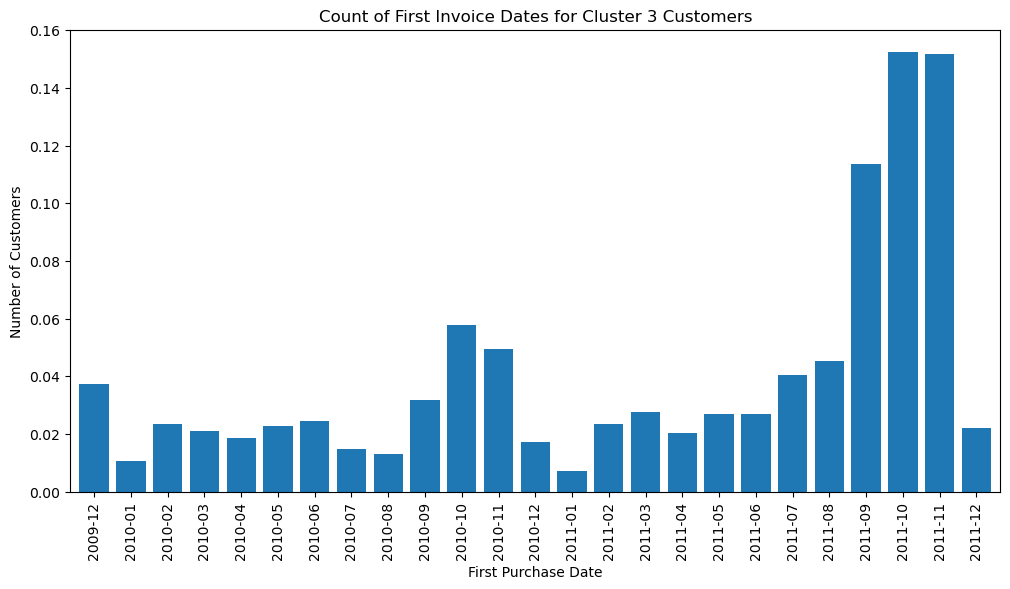

YearMonth
2011-10     0.1525974025974026
2011-11    0.15178571428571427
2011-09    0.11363636363636363
2010-10    0.05762987012987013
2010-11   0.049512987012987016
2011-08   0.045454545454545456
2011-07   0.040584415584415584
2009-12   0.037337662337662336
2010-09    0.03165584415584415
2011-03   0.027597402597402596
2011-05   0.026785714285714284
2011-06   0.026785714285714284
2010-06   0.024350649350649352
2011-02    0.02353896103896104
2010-02    0.02353896103896104
2010-05   0.022727272727272728
2011-12   0.021915584415584416
2010-03   0.021103896103896104
2011-04   0.020292207792207792
2010-04   0.018668831168831168
2010-12   0.017045454545454544
2010-07    0.01461038961038961
2010-08   0.012987012987012988
2010-01   0.010551948051948052
2011-01   0.007305194805194805
Freq: M, Name: proportion, dtype: float64

In [1115]:
first_invoice_dates = c3.groupby('Customer ID')['YearMonth'].min()

# Extract just the date (or month-year for aggregation)
# first_invoice_dates = first_invoice_dates.dt.date  # Change to .dt.to_period('M') for monthly aggregation

# Create a count plot
plt.figure(figsize=(12, 6))
first_invoice_dates.value_counts(normalize=True).sort_index().plot(kind='bar', width=0.8)
plt.xlabel('First Purchase Date')
plt.ylabel('Number of Customers')
plt.title('Count of First Invoice Dates for Cluster 3 Customers')
plt.xticks(rotation=90)  # Rotate for readability
plt.show()

first_invoice_dates.value_counts(normalize=True, ascending=False)

In [1135]:
## first purchase for cluster 3 sice ...
#december:
print(f'december: {round(0.021915584415584416,2)}%')
# november
print(f'november: {round(0.021915584415584416+0.15178571428571427,2)}%')
# october
print(f'October: {round(0.021915584415584416+0.15178571428571427+0.1525974025974026,2)}%')
#september
print(f'September: {round(0.021915584415584416+0.15178571428571427+0.1525974025974026+0.11363636363636363 ,2)}%')
#august
print(f'August: {round(0.021915584415584416+0.15178571428571427+0.1525974025974026+0.11363636363636363+0.045454545454545456,2)}%')
# july
print(f'July: {round(0.021915584415584416+0.15178571428571427+0.1525974025974026+0.11363636363636363+0.045454545454545456+0.040584415584415584,2)}%')



december: 0.02%
november: 0.17%
October: 0.33%
September: 0.44%
August: 0.49%
July: 0.53%


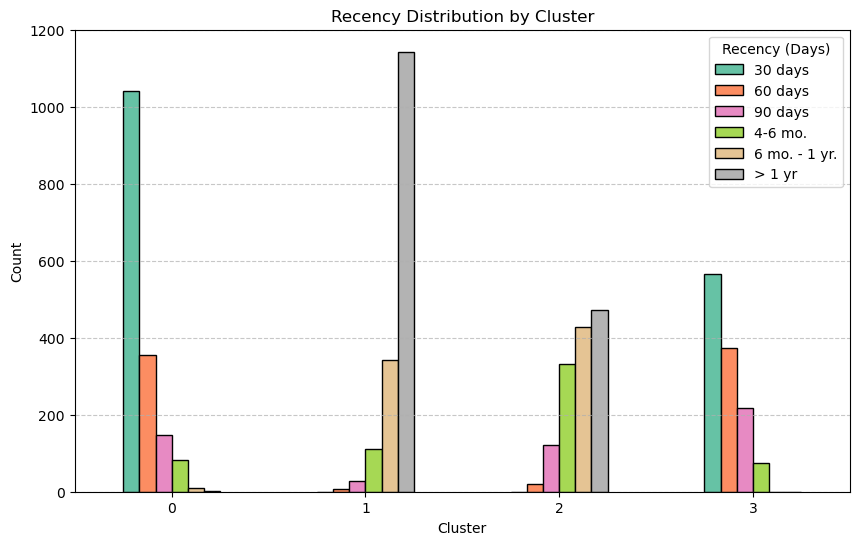

In [1033]:
# Define bins and labels
bins = [0, 30, 60, 90, 183, 365, 750]
labels = ['30 days', '60 days', '90 days', '4-6 mo.', '6 mo. - 1 yr.', '> 1 yr']

# Create the 'Lifespan_bin' column
labeled_rfm_expanded['recency_bin'] = pd.cut(labeled_rfm_expanded['Recency'], bins=bins, labels=labels, right=False)

# Count occurrences of each bin per cluster
bin_counts = labeled_rfm_expanded.groupby(['k4_cluster', 'recency_bin'])['Recency'].count().unstack()

# Convert counts 
# Plot the bar chart

bin_counts.plot(kind='bar', figsize=(10, 6), edgecolor='black', colormap='Set2')

plt.title('Recency Distribution by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.legend(title='Recency (Days)')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.savefig("../Images/recency_by_cluster.png", dpi=300, bbox_inches="tight")  # Save as PNG
plt.savefig("../Images/recency_by_cluster.svg", dpi=300, bbox_inches="tight")  # Save as SVG
# Show the plot
plt.show()

In [1070]:
labeled_has_id[labeled_has_id.k4_cluster==3].describe()


,Quantity,InvoiceDate,Price,Sales,k2_cluster,k4_cluster
count,64584.0,64584,64584.0,64584.0,64584.0,64584.0
mean,7.893874643874644,2011-06-23 02:49:42.866035200,2.8748015297906604,12.63476173665304,0.6530874520004954,3.0
min,1.0,2009-12-01 13:41:00,0.001,0.001,0.0,3.0
25%,1.0,2011-02-25 11:56:00,0.85,3.3,0.0,3.0
50%,4.0,2011-09-29 18:30:00,1.65,8.85,1.0,3.0
75%,12.0,2011-11-09 13:58:00,3.75,16.5,1.0,3.0
max,1500.0,2011-12-09 12:50:00,2033.1,3861.0,1.0,3.0
std,16.658506978178682,NaN,10.413347886455092,28.390116121078876,0.47599132360723767,0.0


In [1080]:
import pandas as pd

# Load your dataset (assuming df is already loaded)
labeled_has_id['InvoiceDate'] = pd.to_datetime(labeled_has_id['InvoiceDate'])  # Ensure InvoiceDate is in datetime format

# Find the most recent transaction date
latest_date = labeled_has_id['InvoiceDate'].max()

# Find first purchase date for each customer
first_purchase = labeled_has_id.groupby('Customer ID')['InvoiceDate'].min().reset_index()
first_purchase.columns = ['Customer ID', 'FirstPurchaseDate']

# Define the 90-day threshold
threshold_date = latest_date - pd.Timedelta(days=(365/2))

# Identify customers who made their first purchase in the last 90 days
new_customers = first_purchase[first_purchase['FirstPurchaseDate'] >= threshold_date]

# Calculate percentage
percentage_new_customers = (len(new_customers) / len(first_purchase)) * 100

print(f"Percentage of customers who made their first purchase in the last 90 days: {percentage_new_customers:.2f}%")


Percentage of customers who made their first purchase in the last 90 days: 15.46%


#### How do the clusters vary in seasonality? (YearMonth, Sales)

In [729]:
sales_per_month = labeled_has_id.groupby('YearMonth')['Sales'].sum()

# Convert to DataFrame for easier visualization
sales_per_month = sales_per_month.reset_index()
sales_per_month.columns = ['YearMonth', 'MonthlySales']



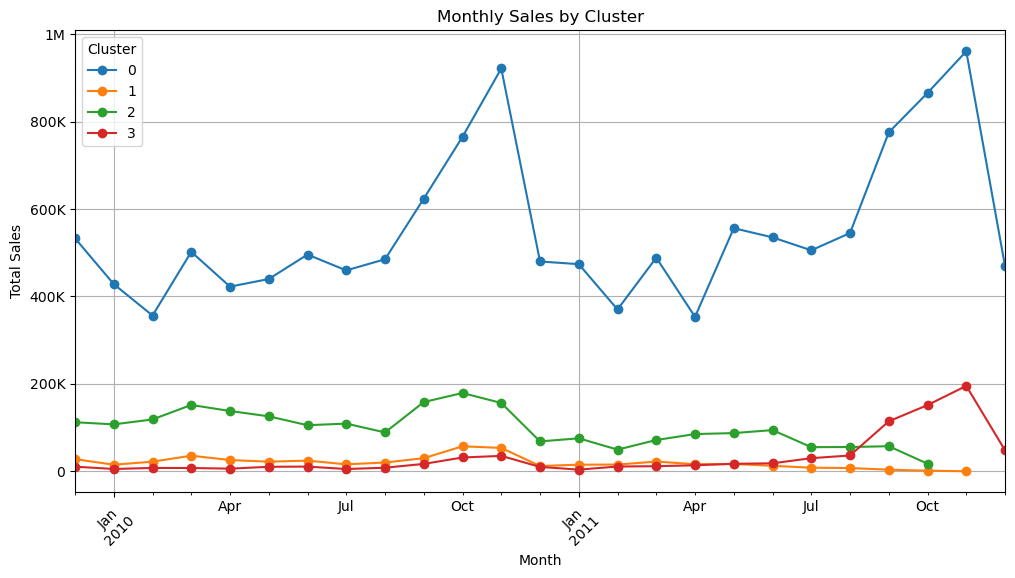

In [733]:
monthly_sales = labeled_has_id.groupby(['YearMonth', 'k4_cluster'])['Sales'].sum().unstack()

# Plot sales trends by cluster
monthly_sales.plot(kind='line', marker='o', figsize=(12, 6))
plt.xlabel("Month")
plt.ylabel("Total Sales")
plt.title("Monthly Sales by Cluster")
plt.legend(title="Cluster")
plt.grid()
plt.xticks(rotation=45)
plt.yticks(ticks=[0, 200000, 400000, 600000, 800000, 1000000], labels=['0', '200K', '400K', '600K', '800K', '1M'])

plt.savefig("../Images/Monthly_Sales.png", dpi=300, bbox_inches="tight")  # Save as PNG
plt.savefig("../Images/Monthly_Sales.svg", dpi=300, bbox_inches="tight")  # Save as SVG

plt.show()

In [1051]:
labeled_has_id[labeled_has_id.k4_cluster==1].groupby(['YearMonth'])['Sales'].sum()
(20073.4+29998.19+57258.61+53454.6+12082.24)/labeled_has_id[labeled_has_id.k4_cluster==1]['Sales'].sum()


0.3599368340121483

### Characteristics - Bivariate

retension rate -- recency and frequency by cluster

identify high value purchases -- aov and clv by cluster

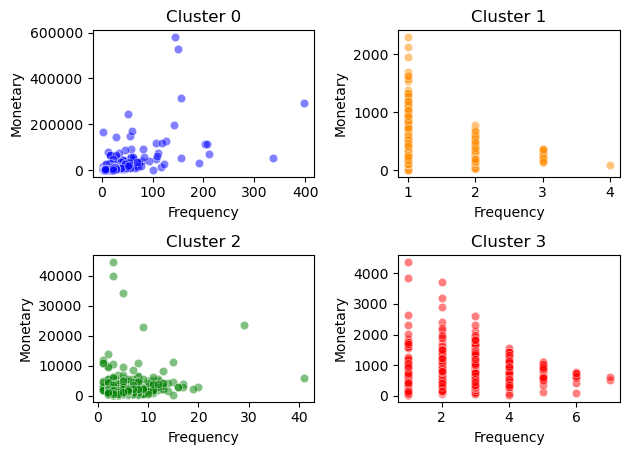

In [723]:
# Retension rate
fig, ax = plt.subplots(2,2)

# cluster 0
sns.scatterplot(data= labeled_rfm_expanded[labeled_rfm_expanded.k4_cluster==0], x='Frequency', y='Monetary', alpha=.5, ax=ax[0,0], color='blue')
ax[0,0].set_title('Cluster 0')

# cluster 1
sns.scatterplot(data= labeled_rfm_expanded[labeled_rfm_expanded.k4_cluster==1], x='Frequency', y='Monetary', alpha=.5, ax=ax[0,1], color='darkorange')
ax[0,1].set_title('Cluster 1')

# cluster 2
sns.scatterplot(data= labeled_rfm_expanded[labeled_rfm_expanded.k4_cluster==2], x='Frequency', y='Monetary', alpha=.5, ax=ax[1,0], color='green')
ax[1,0].set_title('Cluster 2')

# cluster 3
sns.scatterplot(data= labeled_rfm_expanded[labeled_rfm_expanded.k4_cluster==3], x='Frequency', y='Monetary', alpha=.5, ax=ax[1,1], color='red')
ax[1,1].set_title('Cluster 3')

fig.suptitle("", fontsize=14, fontweight="bold")
# plt.subplots_adjust(wspace=0.4, hspace=0.5, top=0.8)  # Adjust top to fit title properly
plt.tight_layout()
plt.show()

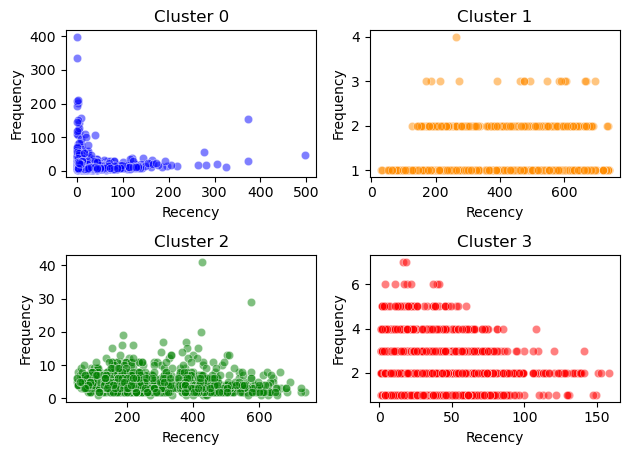

In [851]:
# Retension rate
fig, ax = plt.subplots(2,2)

# cluster 0
sns.scatterplot(data= labeled_rfm_expanded[labeled_rfm_expanded.k4_cluster==0], y='Frequency', x='Recency', alpha=.5, ax=ax[0,0], color='blue')
ax[0,0].set_title('Cluster 0')

# cluster 1
sns.scatterplot(data= labeled_rfm_expanded[labeled_rfm_expanded.k4_cluster==1], y='Frequency', x='Recency', alpha=.5, ax=ax[0,1], color='darkorange')
ax[0,1].set_title('Cluster 1')

# cluster 2
sns.scatterplot(data= labeled_rfm_expanded[labeled_rfm_expanded.k4_cluster==2], y='Frequency', x='Recency', alpha=.5, ax=ax[1,0], color='green')
ax[1,0].set_title('Cluster 2')

# cluster 3
sns.scatterplot(data= labeled_rfm_expanded[labeled_rfm_expanded.k4_cluster==3], y='Frequency', x='Recency', alpha=.5, ax=ax[1,1], color='red')
ax[1,1].set_title('Cluster 3')

fig.suptitle("", fontsize=14, fontweight="bold")
# plt.subplots_adjust(wspace=0.4, hspace=0.5, top=0.8)  # Adjust top to fit title properly
plt.tight_layout()
plt.show()

In [865]:
labeled_rfm_expanded.AOV.describe([.75,.95,.99])


count               5878.0
mean    385.18084076162313
std     1214.2864588587054
min      2.950000047683716
50%     279.24268886021207
75%     414.90245351070115
95%      891.1644897460932
99%     1963.8104846191238
max               84236.25
Name: AOV, dtype: float64

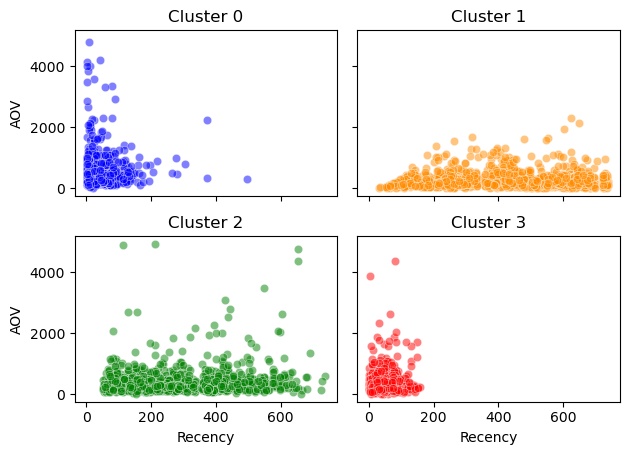

In [869]:


# Retension rate
fig, ax = plt.subplots(2,2, sharex=True, sharey=True)

# cluster 0
sns.scatterplot(data= labeled_rfm_expanded[(labeled_rfm_expanded.k4_cluster==0)&(labeled_rfm_expanded.AOV<5000)], y='AOV', x='Recency', alpha=.5, ax=ax[0,0], color='blue')
ax[0,0].set_title('Cluster 0')

# cluster 1
sns.scatterplot(data= labeled_rfm_expanded[(labeled_rfm_expanded.k4_cluster==1)&(labeled_rfm_expanded.AOV<5000)], y='AOV', x='Recency', alpha=.5, ax=ax[0,1], color='darkorange')
ax[0,1].set_title('Cluster 1')

# cluster 2
sns.scatterplot(data= labeled_rfm_expanded[(labeled_rfm_expanded.k4_cluster==2)&(labeled_rfm_expanded.AOV<5000)], y='AOV', x='Recency', alpha=.5, ax=ax[1,0], color='green')
ax[1,0].set_title('Cluster 2')

# cluster 3
sns.scatterplot(data= labeled_rfm_expanded[(labeled_rfm_expanded.k4_cluster==3)&(labeled_rfm_expanded.AOV<5000)], y='AOV', x='Recency', alpha=.5, ax=ax[1,1], color='red')
ax[1,1].set_title('Cluster 3')

fig.suptitle("", fontsize=14, fontweight="bold")
# plt.subplots_adjust(wspace=0.4, hspace=0.5, top=0.8)  # Adjust top to fit title properly
plt.tight_layout()
plt.show()

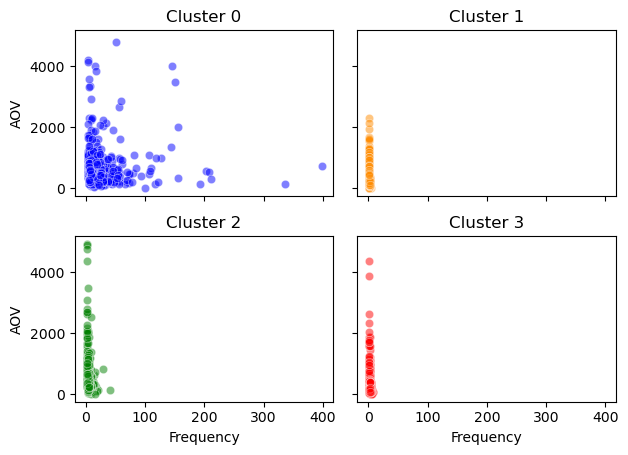

In [883]:


# Retension rate
fig, ax = plt.subplots(2,2, sharex=True, sharey=True)

# cluster 0
sns.scatterplot(data= labeled_rfm_expanded[(labeled_rfm_expanded.k4_cluster==0)&(labeled_rfm_expanded.AOV<5000)], y='AOV', x='Frequency', alpha=.5, ax=ax[0,0], color='blue')
ax[0,0].set_title('Cluster 0')

# cluster 1
sns.scatterplot(data= labeled_rfm_expanded[(labeled_rfm_expanded.k4_cluster==1)&(labeled_rfm_expanded.AOV<5000)], y='AOV', x='Frequency', alpha=.5, ax=ax[0,1], color='darkorange')
ax[0,1].set_title('Cluster 1')

# cluster 2
sns.scatterplot(data= labeled_rfm_expanded[(labeled_rfm_expanded.k4_cluster==2)&(labeled_rfm_expanded.AOV<5000)], y='AOV', x='Frequency', alpha=.5, ax=ax[1,0], color='green')
ax[1,0].set_title('Cluster 2')

# cluster 3
sns.scatterplot(data= labeled_rfm_expanded[(labeled_rfm_expanded.k4_cluster==3)&(labeled_rfm_expanded.AOV<5000)], y='AOV', x='Frequency', alpha=.5, ax=ax[1,1], color='red')
ax[1,1].set_title('Cluster 3')

fig.suptitle("", fontsize=14, fontweight="bold")
# plt.subplots_adjust(wspace=0.4, hspace=0.5, top=0.8)  # Adjust top to fit title properly
plt.tight_layout()
plt.show()

In [ ]:
(labeled_rfm_expanded.k4_cluster==0)&(labeled_rfm_expanded.AOV<5000)

In [739]:
labeled_rfm_expanded.columns

Index(['Customer ID', 'Recency', 'Frequency', 'Monetary', 'AOV', 'Lifespan',
       'CLV', 'k2_cluster', 'k4_cluster', 'Lifespan_bin', 'Frequency_bin',
       'Adj_AOV'],
      dtype='object')

In [853]:
labeled_rfm_expanded[['Recency', 'Frequency', 'Monetary',]].describe([.25,.5,.75,.9,.95,.99])

,Recency,Frequency,Monetary
count,5878.0,5878.0,5878.0
mean,201.331915617557,6.289384144266758,2955.9040941490307
std,209.33870672957246,13.009405882310057,14440.852696942122
min,1.0,1.0,2.95
25%,26.0,1.0,342.28
50%,96.0,3.0,867.74
75%,380.0,7.0,2248.305
90%,535.0,13.0,5465.741000000001
95%,625.0,21.0,9374.226999999993
99%,726.0,46.0,29205.900999999645


In [963]:
# data excluded from extreme graph cutoffs:
print('Frequency')
print(labeled_rfm_expanded[labeled_rfm_expanded.Frequency>46].k4_cluster.value_counts())
print()
print('Monetary')
print(labeled_rfm_expanded[labeled_rfm_expanded.Monetary>10000].k4_cluster.value_counts())


Frequency
k4_cluster
0    58
Name: count, dtype: int64

Monetary
k4_cluster
0    249
2     12
Name: count, dtype: int64


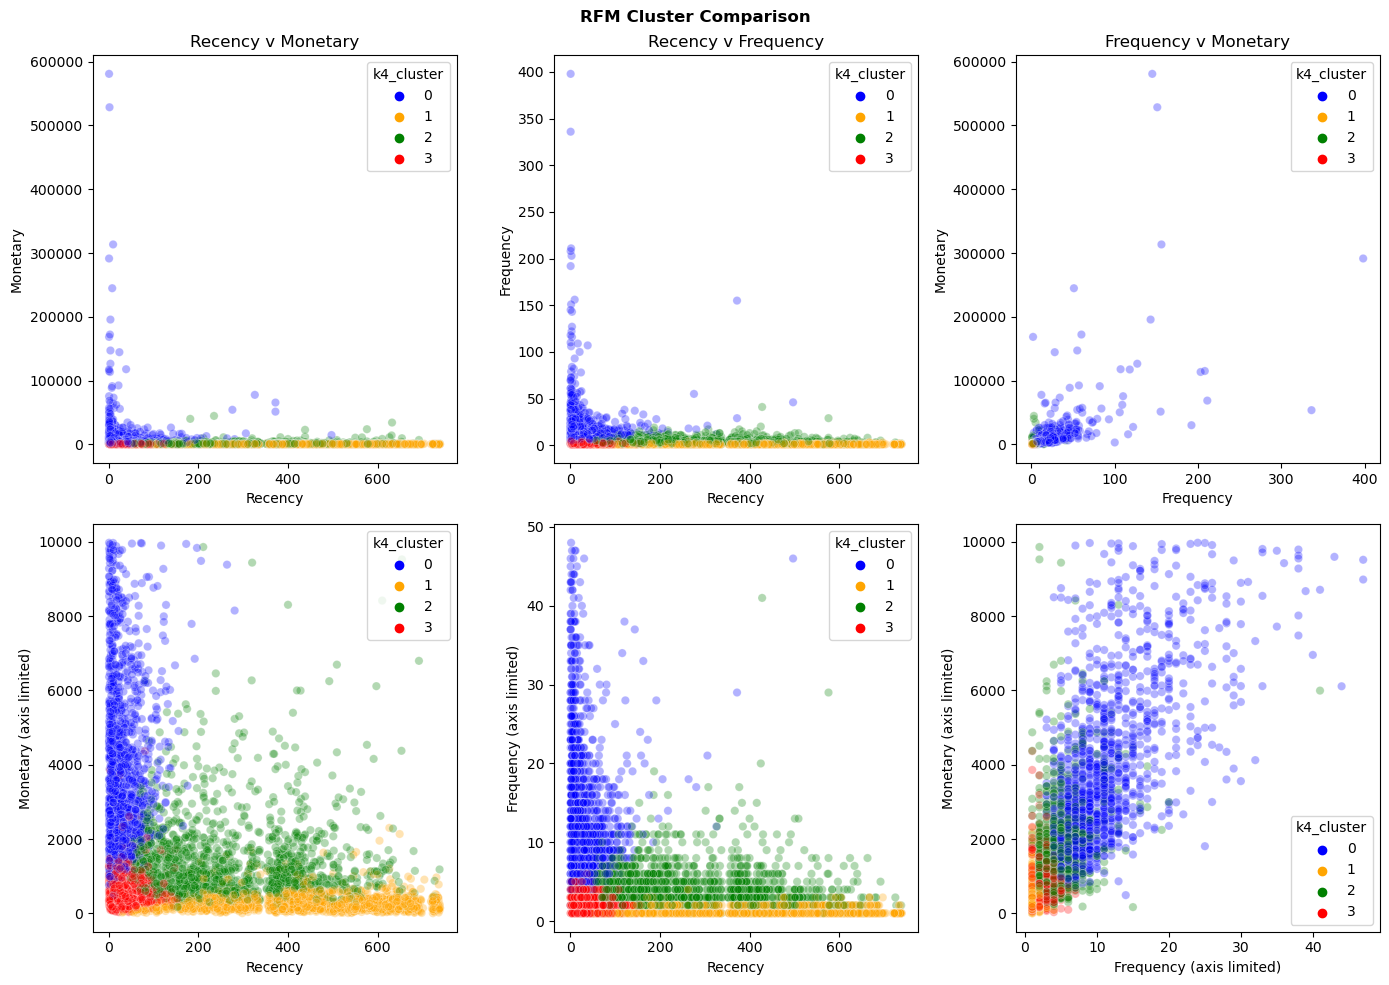

In [1064]:
cmap={}
fig, ax = plt.subplots(2,3, figsize=(14,10))
custom_palette = {0: "blue", 1: "orange", 2: "green", 3: "red"}

sns.scatterplot(data=labeled_rfm_expanded,x='Recency', y='Monetary', hue='k4_cluster', ax=ax[0,0],alpha=.3, palette=custom_palette)
ax[0,0].set_title('Recency v Monetary')
sns.scatterplot(data=labeled_rfm_expanded,x='Recency', y='Frequency', hue='k4_cluster', ax=ax[0,1], palette=custom_palette,alpha=.3)
ax[0,1].set_title('Recency v Frequency')
sns.scatterplot(data=labeled_rfm_expanded,x='Frequency', y='Monetary', hue='k4_cluster', ax=ax[0,2], palette=custom_palette,alpha=.3)
ax[0,2].set_title('Frequency v Monetary')

sns.scatterplot(data=labeled_rfm_expanded[labeled_rfm_expanded.Monetary<10000],x='Recency', y='Monetary', hue='k4_cluster', ax=ax[1,0],alpha=.3, palette=custom_palette)
ax[1,0].set_ylabel('Monetary (axis limited)')
sns.scatterplot(data=labeled_rfm_expanded[labeled_rfm_expanded.Frequency<50],x='Recency', y='Frequency', hue='k4_cluster', ax=ax[1,1],alpha=.3, palette=custom_palette)
ax[1,1].set_ylabel('Frequency (axis limited)')
sns.scatterplot(data=labeled_rfm_expanded[(labeled_rfm_expanded.Frequency<50)&(labeled_rfm_expanded.Monetary<10000)],x='Frequency', y='Monetary', hue='k4_cluster', ax=ax[1,2], palette=custom_palette,alpha=.3)
ax[1,2].set_xlabel('Frequency (axis limited)')
ax[1,2].set_ylabel('Monetary (axis limited)')

fig.suptitle('RFM Cluster Comparison', fontweight='bold')
plt.tight_layout()

plt.savefig("../Images/rfm_scatters.png", dpi=300, bbox_inches="tight")  # Save as PNG
plt.savefig("../Images/rfm_scatters.svg", dpi=300, bbox_inches="tight")  # Save as SVG

plt.show()

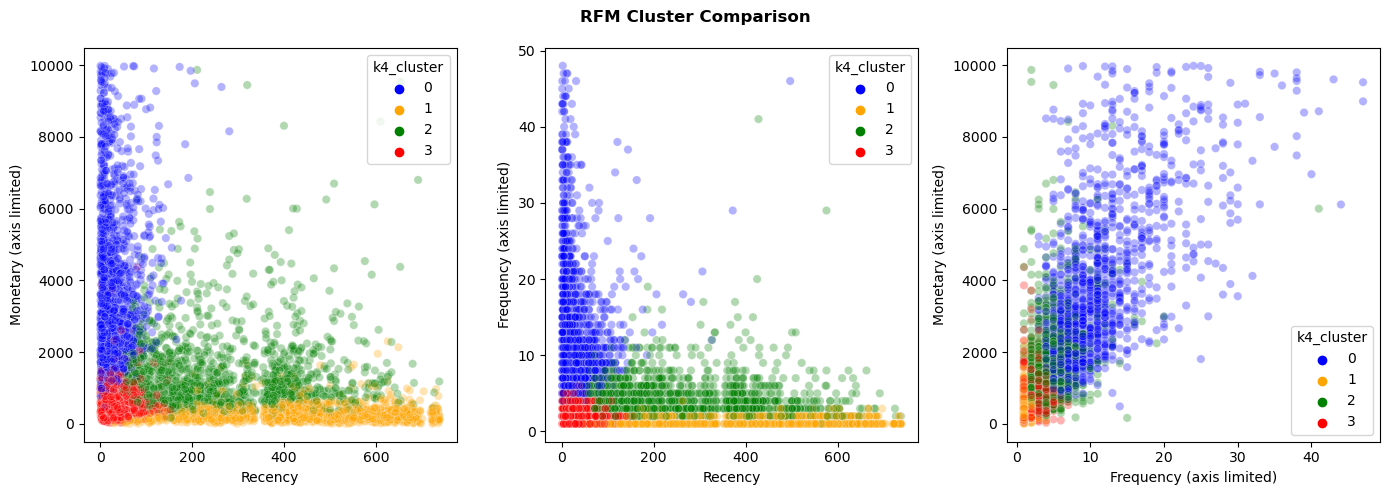

In [1149]:
cmap={}
fig, ax = plt.subplots(1,3, figsize=(14,5))
custom_palette = {0: "blue", 1: "orange", 2: "green", 3: "red"}


sns.scatterplot(data=labeled_rfm_expanded[labeled_rfm_expanded.Monetary<10000],x='Recency', y='Monetary', hue='k4_cluster', ax=ax[0],alpha=.3, palette=custom_palette)
ax[0].set_ylabel('Monetary (axis limited)')
sns.scatterplot(data=labeled_rfm_expanded[labeled_rfm_expanded.Frequency<50],x='Recency', y='Frequency', hue='k4_cluster', ax=ax[1],alpha=.3, palette=custom_palette)
ax[1].set_ylabel('Frequency (axis limited)')
sns.scatterplot(data=labeled_rfm_expanded[(labeled_rfm_expanded.Frequency<50)&(labeled_rfm_expanded.Monetary<10000)],x='Frequency', y='Monetary', hue='k4_cluster', ax=ax[2], palette=custom_palette,alpha=.3)
ax[2].set_xlabel('Frequency (axis limited)')
ax[2].set_ylabel('Monetary (axis limited)')

fig.suptitle('RFM Cluster Comparison', fontweight='bold')
plt.tight_layout()

plt.savefig("../Images/rfm_scatters_limited.png", dpi=300, bbox_inches="tight")  # Save as PNG
plt.savefig("../Images/rfm_scatters_limited.svg", dpi=300, bbox_inches="tight")  # Save as SVG

plt.show()

In [ ]:

sns.scatterplot(data=labeled_rfm_expanded,x='Recency', y='AOV', hue='k4_cluster', ax=ax[0,0],alpha=.5, palette=custom_palette)
sns.scatterplot(data=labeled_rfm_expanded,x='Recency', y='AOV', hue='k4_cluster', ax=ax[0,1], palette=custom_palette,alpha=.5)
sns.scatterplot(data=labeled_rfm_expanded[labeled_rfm_expanded.AOV<10000],x='
sns.scatterplot(data=labeled_rfm_expanded,x='Recency', y='Monetary', hue='k4_cluster', ax=ax[0,0],alpha=.5, palette=custom_palette)
sns.scatterplot(data=labeled_rfm_expanded,x='Recency', y='Frequency', hue='k4_cluster', ax=ax[0,1], palette=custom_palette,alpha=.5)
sns.scatterplot(data=labeled_rfm_expanded[labeled_rfm_expanded.Monetary<10000],x='Recency', y='Monetary', hue='k4_cluster', ax=ax[1,0],alpha=.5, palette=custom_palette)
sns.scatterplot(data=labeled_rfm_expanded[labeled_rfm_expanded.Frequency<50],x='Recency', y='Frequency', hue='k4_cluster', ax=ax[1,1],alpha=.5, palette=custom_palette)

plt.show()', y='Monetary', hue='k4_cluster', ax=ax[1,0],alpha=.5, palette=custom_palette)
sns.scatterplot(data=labeled_rfm_expanded[labeled_rfm_expanded.Frequency<50],x='Recency', y='Frequency', hue='k4_cluster', ax=ax[1,1],alpha=.5, palette=custom_palette)

plt.show()

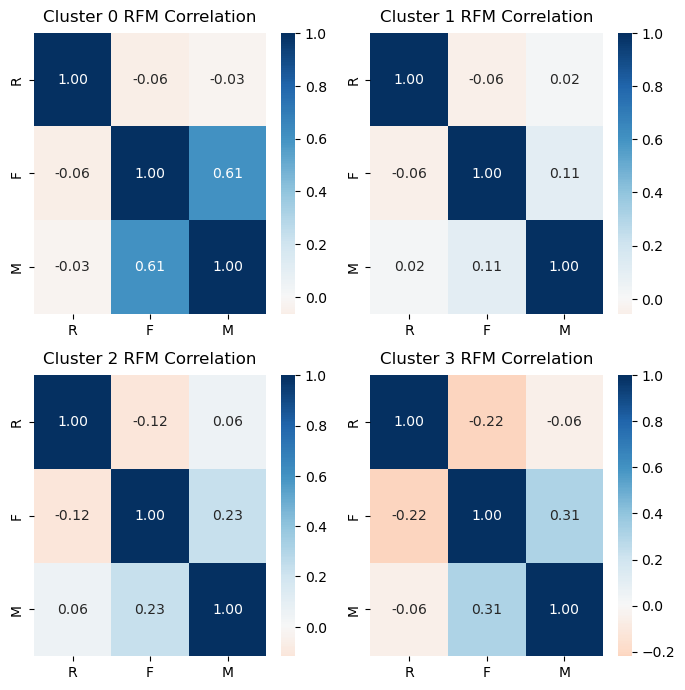

In [837]:
rename_dict = {'Recency': 'R', 'Frequency': 'F', 'Monetary': 'M'}

fix, ax= plt.subplots(2,2, figsize=(7,7))
sns.heatmap(labeled_rfm_expanded[labeled_rfm_expanded.k4_cluster == 0][['Recency', 'Frequency', 'Monetary']].rename(columns=rename_dict).corr(), annot=True, cmap='RdBu', fmt=".2f", center=0, ax=ax[0,0])
ax[0,0].set_title('Cluster 0 RFM Correlation', y=1.01)

sns.heatmap(labeled_rfm_expanded[labeled_rfm_expanded.k4_cluster == 1][['Recency', 'Frequency', 'Monetary']].rename(columns=rename_dict).corr(), annot=True, cmap='RdBu', fmt=".2f", center=0, ax=ax[0,1])
ax[0,1].set_title('Cluster 1 RFM Correlation', y=1.01)

sns.heatmap(labeled_rfm_expanded[labeled_rfm_expanded.k4_cluster == 2][['Recency', 'Frequency', 'Monetary']].rename(columns=rename_dict).corr(), annot=True, cmap='RdBu', fmt=".2f", center=0, ax=ax[1,0])
ax[1,0].set_title('Cluster 2 RFM Correlation', y=1.01)

sns.heatmap(labeled_rfm_expanded[labeled_rfm_expanded.k4_cluster == 3][['Recency', 'Frequency', 'Monetary']].rename(columns=rename_dict).corr(), annot=True, cmap='RdBu', fmt=".2f", center=0, ax=ax[1,1])
ax[1,1].set_title('Cluster 3 RFM Correlation', y=1.01)

plt.tight_layout()
# plt.savefig("../Images/rfm_correlation.png", dpi=300, bbox_inches="tight")  # Save as PNG
# plt.savefig("../Images/rfm_correlation.svg", dpi=300, bbox_inches="tight")  # Save as SVG
plt.show()

In [769]:
sns.pairplot(labeled_rfm_expanded, vars=['Recency', 'Frequency', 'Monetary'], hue='k4_cluster', alpha=.3)


TypeError: pairplot() got an unexpected keyword argument 'alpha'

In [895]:
labeled_rfm_expanded.groupby('k4_cluster')[['Recency', 'Frequency', 'Monetary']].describe().T

k4_cluster                       0                   1                  2  \
Recency   count             1640.0              1634.0             1372.0   
          mean   31.35487804878049   431.3665850673195 275.67419825072886   
          std    37.94192489878149  172.94856463915454  151.8913086151934   
          min                  1.0                30.0               50.0   
          25%                  8.0               302.0              150.0   
          50%                 20.0               423.0              248.5   
          75%                 42.0              572.75              393.0   
          max                497.0               739.0              738.0   
Frequency count             1640.0              1634.0             1372.0   
          mean  15.778048780487804   1.233782129742962   4.49198250728863   
          std    21.67755845165014 0.45136740359725036  2.646566084672703   
          min                  2.0                 1.0                1.0   
          25%                  7.0                 1.0                3.0   
          50%                 11.0                 1.0                4.0   
          75%                 17.0                 1.0                5.0   
          max                398.0                 4.0               41.0   
Monetary  count             1640.0              1634.0             1372.0   
          mean   8421.133735957317   293.9231892552019  1652.967198090379   
          std    26467.18646169096   231.6748679569933 2373.8269196145875   
          min               489.54                2.95             167.42   
          25%   2268.0350000000003  141.58999999999997            782.635   
          50%   3770.2200000000003               240.2 1168.2199999999998   
          75%            6948.4025              374.35          1843.5275   
          max            580987.06              2300.4            44534.3   

k4_cluster                       3  
Recency   count             1232.0  
          mean    39.7150974025974  
          std     29.9031607781419  
          min                  1.0  
          25%                 17.0  
          50%                 32.5  
          75%                 58.0  
          max                158.0  
Frequency count             1232.0  
          mean    2.36525974025974  
          std    1.174337401326921  
          min                  1.0  
          25%                  1.0  
          50%                  2.0  
          75%                  3.0  
          max                  7.0  
Monetary  count             1232.0  
          mean   662.3404638108766  
          std   453.56579568940913  
          min                 30.0  
          25%              342.235  
          50%               571.37  
          75%               887.25  
          max              4366.78

## Summary

**Centroid Eval** <br>
The centroids Suggest these preliminary profiles for customers:

* Cluster 0: High recency, high frequency, high lifetime spend
    * Frequent, Loyal customers
* Cluster 1: low recency, frequency and spend
    * one time purchases / churned
* Cluster 2: moderately low recency, slighty elevated frequency and spend
    * occasional buyers / risk of churn
* Cluster 3: moderayely high recency low frequency , low spend
    * new customers 


**How often do they buy?** Frequency

* Cluster 0: Frequent Buyers - these customers purchase most frequently - IQR 7-17
    - 25,876 purchases (69.99%)
* Cluster 1: One-Time Buyers - these customers purchase once or, rarely, twice
    - 2,016 purchases (5.45%)
* Cluster 2: Ocasional Buyers - these customers purchase second most- IQR 3-5
    - 6,163 purchases (16.67%) 
* Cluster 3: Try Again Buyers - these customers purchase 1-3 times
    - 2,914 purchases (7.88%)
 
**Has 2 Graphs** - Bar for frequency distribution by cluster and Pie for percent of total transactions.

**How Much do they spend? - Total Spend**    - Monatary
* Cluster 0: Frequent Buyers - \$13,810,659 spent (79.49%)
* Cluster 1: One-Time Buyers - \$480,270 spent (2.76%)
* Cluster 2: Ocasional Buyers - \$2,267,871.00 spent (13.05%) 
* Cluster 3: Try Again Buyers - \$816,003 spent (4.7%)

**How Much do they spend? - Average order value** - AOV
* Cluster 0: Frequent Buyers - Median: 351 - IQR 249-509
* Cluster 1: One-Time Buyers - Median: 197 - IQR 124-311
* Cluster 2: Ocasional Buyers - Median: 306 - IQR 199-445
* Cluster 3: Try Again Buyers - Median: 256 - IQR 169-371

**How Much do they spend? - Average order value by order - AOV/Frequency**   - 'Adjusted AOV'
* Cluster 0: Frequent Buyers - Mean: 76.44 - Median: 31.59 - IQR 18.22-55.32
    * lowest adjusted AOV --> highest AOV and highest frequency suggests AOV is inflated by Frequent Purchases
* Cluster 1: One-Time Buyers - Mean: 235.79 - Median: 158.97 - IQR 98.37-309.76
    * highest adjusted AOV --> high one time purchases
* Cluster 2: Ocasional Buyers - Mean: 167.21 - Median: 40.83 - IQR 40.83-146.22
    * 2nd lowest adjust AOV --> occasional buyers with higher AOV
* Cluster 3: Try Again Buyers - Mean: 199.52 - Median: 118.66 - IQR 65.49-219.37
    * 2nd highest adjusted AOV --> several bigger purchases

**Do clusters differ by Country?** <br> (Country)
Percent of purchases from UK by cluster:
* Cluster 0: 89.05999999999999%; percent difference: -0.89%
* Cluster 1: 93.14%; percent difference: 3.65%
* Cluster 2: 91.23%; percent difference: 1.52%
* Cluster 3: 92.43%; percent difference: 2.86%
<br>
- cluster 0 is most representative of the dataset by country distribution.  It has a slightly lower portion of UK but slightly higher percentage of the other top 5 countries.  It includes all but 2 of the purchases from Ireland.

## NOTES to self

### errors and follow up:




**Errors:**
* CLV should have been calculated as a historic clv insteay of as AOV * Freq
    * for Monetary should have used a rolling 1, 3, or 6 months sales average or total insead of total sales over the period.
        *  tried rolling total sales with no change
* Did not multiply recency by -1 before modeling.
    * the recency values are inverse of what they should be and could have affected the results fo the model. and negatively impact interpretability


**Follow-up:**
* further segment loyal customers to get better picture of spending habbits.
* further segment by customer basked
    * ther is no information on type of products in the dataset other than the description and stock code.  further information about the type could allow for further segmentation on the basis of type of products purchased. 

### sub-clustring

In [211]:
sub_df = pd.read_csv('../Data/sub_df.csv', dtype={'Customer ID':'string'})
sub_df

,Customer ID,sub
0,12346.0,1
1,12347.0,2
2,12348.0,1
3,12349.0,0
4,12352.0,2
...,...,...
5873,18281.0,5
5874,18282.0,3
5875,18284.0,5
5876,18285.0,5


In [212]:
test = labeled_rfm_expanded.merge(sub_df[['Customer ID', 'sub']], on='Customer ID', how='left')


In [213]:
test.columns

Index(['Customer ID', 'Recency', 'Frequency', 'Monetary', 'AOV', 'Lifespan',
       'CLV', 'k2_cluster', 'k4_cluster', 'Lifespan_bin', 'Frequency_bin',
       'Adj_AOV', 'sub'],
      dtype='object')

In [214]:
test.groupby('sub')[['Recency', 'Frequency', 'Monetary']].describe().round(2).T

sub                   0        1         2      3        4      5
Recency   count  1006.0    838.0     973.0  762.0   1082.0 1217.0
          mean    27.04   167.76     19.92  55.98   359.58 463.88
          std     21.51   121.64     21.72  35.69    141.1 160.02
          min       1.0     36.0       1.0    1.0     78.0   64.0
          25%      10.0     78.0       5.0   28.0    243.0  372.0
          50%      22.0    127.0      14.0   52.0    376.0  444.0
          75%     38.75    214.0      28.0   75.0    441.0  598.0
          max     107.0    692.0     276.0  177.0    738.0  739.0
Frequency count  1006.0    838.0     973.0  762.0   1082.0 1217.0
          mean     4.44     7.66     21.19   1.56     2.74   1.08
          std      1.86     6.46     26.25   0.73      1.1   0.29
          min       1.0      2.0       2.0    1.0      1.0    1.0
          25%       3.0      5.0      11.0    1.0      2.0    1.0
          50%       4.0      7.0      14.0    1.0      2.0    1.0
          75%       5.0      9.0      23.0    2.0      3.0    1.0
          max      14.0    155.0     398.0    6.0      9.0    4.0
Monetary  count  1006.0    838.0     973.0  762.0   1082.0 1217.0
          mean  1286.42   3214.8  12144.56 403.65   904.95 232.76
          std    692.91  4884.91  33648.99 298.19   926.77 143.63
          min    252.49   167.42   1543.18   20.8   173.95   2.95
          25%     787.0  1580.36   3602.29 200.58   471.39 127.65
          50%   1127.78  2247.52   5652.74 341.96   730.25 203.14
          75%   1631.56  3433.52   9942.53 508.34   1062.1 314.66
          max   5001.21 77556.46 580987.06 2626.3 13916.34 818.29


save labeled_rfm_expanded and labeled_has_id for export

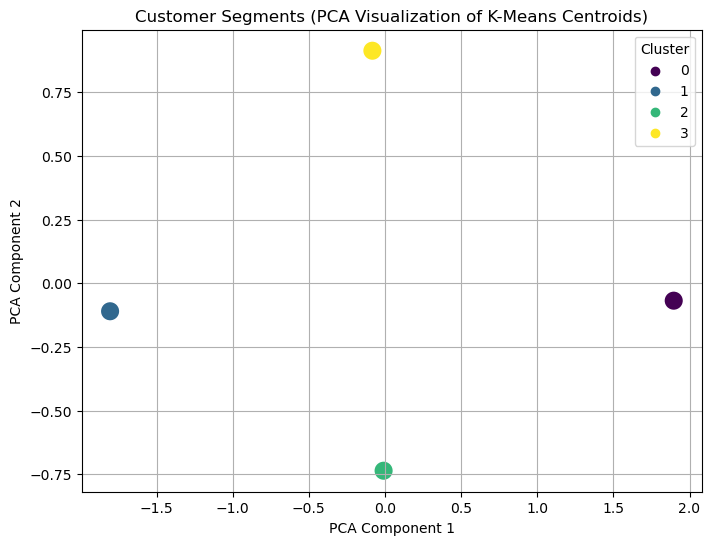

In [216]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Creating the centroids4 dataset with Cluster as the index
centroids4 = pd.DataFrame({
    "Recency": [-0.9660233855247498, 1.0283008813858032, 0.6090972423553467, -0.7509269714355469],
    "Frequency": [1.190121054649353, -1.0848933458328247, 0.260760635137558, -0.43853896856307983],
    "Monetary": [1.1011698246002197, -1.0310698747634888, 0.24631133675575256, -0.37525156140327454]
}, index=[0, 1, 2, 3])  # Cluster as the index

# Applying PCA for 2D visualization (reducing 3 features: Recency, Frequency, Monetary)
pca = PCA(n_components=2)
centroids_pca = pca.fit_transform(centroids4)

# Adding PCA components to the dataset
centroids4["PCA1"] = centroids_pca[:, 0]
centroids4["PCA2"] = centroids_pca[:, 1]

# Plotting the centroids in PCA space
plt.figure(figsize=(8, 6))
sns.scatterplot(data=centroids4, x="PCA1", y="PCA2", hue=centroids4.index, palette="viridis", s=200)
plt.title("Customer Segments (PCA Visualization of K-Means Centroids)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()
